given camera angle of the task and the change of angle, create a weight distribution in shape of a cone and shift the weight distribution as camera/sub angle changes

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import copy

In [200]:
#NOTE: The whole class can be sped up, if necessary, with vectorizing in numpy
#TODO: Multiple objects


class particleFilter():
    particleMat = []
    def __init__(self, angleAmount):
        ''' 
        angleAmount is the number of angle we want in particleMat. 
        coordinate: say we use polar with 0 in Cartesian positve x direction. It goes [0,len(angleAmount)), 
        which we will output by mapping this to [0,360), or whatever the sub takes
        '''
        self.particles = angleAmount
        self.particleMat = [ 1 for i in range(self.particles) ]
        self.i_to_angle = 360/angleAmount
    
    def resetWeights(self):
        self.particleMat = [ 1 for i in range(self.particles) ]
        
    def addTask(self):
        pass
    
    def updateAngle(self,newAngle,stdev,mode):
        '''
        data will be the input data in angles, most likely one single input and error in angle. 
        angle might need adjustment to fit our coordinates.
        error might need treatment to become standard deviation
        '''
        '''
        increase prob for "angle", bc we see angle.
        '''
        if mode == 'angle':
            if newAngle <= 319:
                newAngle = -math.degrees(np.arctan((319.5-newAngle)/725.24))
            else:
                newAngle = math.degrees(np.arctan((newAngle-319.5)/725.24))
                
        #Might want to change to adust number of measurements to change weights
        fWeight = 0.09
        
        for i in range(len(self.particleMat)):
            angle = int(round(i*self.i_to_angle))
            angleDiff = min([math.fabs(angle - newAngle),math.fabs(newAngle-angle+360)])
            gaussDelta =  math.e**( -angleDiff*angleDiff / (2* stdev**2) )*360/math.sqrt(2*math.pi*stdev**2)
            self.particleMat[i] = fWeight*gaussDelta+ (1-fWeight)*self.particleMat[i]
        
        #normalize
        if np.sum(self.particleMat)>360:
            total = 360/np.sum(self.particleMat)
            self.particleMat = [i*total for i in self.particleMat]
        
    def updateSubmarineAngle(self,cameraChange):
        cameraChange = cameraChange % 360
        newAng = [0 for i in range(len(self.particleMat))]
        for i in range(len(self.particleMat)):
            angIdx = int(round(cameraChange/self.i_to_angle))
            if i-angIdx>=0:
                newAng[i-angIdx]=self.particleMat[i]
            else:
                newAng[i+int(round((360-cameraChange)/self.i_to_angle))]=self.particleMat[i]
        self.particleMat = newAng
        
    def getPredictedState(self):
        angles = [x*self.i_to_angle for x in range(0, self.particles)]
        max_x = angles[array(self.particleMat).argmax()] 
        stDev = np.std(np.array(self.particleMat), axis = 0)
        return max_x, self.particleMat[(int)(max_x/self.i_to_angle)]
    

Proposed Move Condition
particle.getPredictedState will return a vector of 3 values:
    1) Predicted angle
    2) Weight at angle
    3) Sum of weights
   
We use quantity 3 to evaluate "accumulation," or whether we had enough measurements to start predicting angle data.

Once the weight at angle is higher than, say, 120, we next use quantity 2 to calculate "certainty." I suggest, based of very crude estimate, a weight of 2.75? as a threshold of certainty.

Our idea is to turn toward that weight, then go forward. Once the angle gets too far from origin, we reset the angle matrix.

(13.0, 2.7617873306277834)


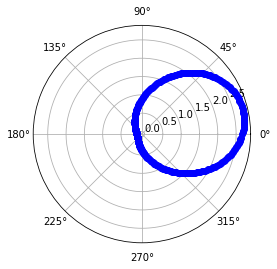

In [201]:
particle = particleFilter(360)
for i in range(15):
    a=particle.updateAngle(0,50,'angle')
    a=particle.updateAngle(0,50,'angle')
    
a = particle.updateSubmarineAngle(-37)
    
for i in range(359):
    plt.polar(i/180*math.pi, particle.particleMat[i],"bo")
print(particle.getPredictedState())